In [ ]:
!python --version

Python 3.10.12


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!pip install scikit-learn

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import time
from tqdm.notebook import tqdm_notebook

import sklearn
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score, adjusted_mutual_info_score, \
                         fowlkes_mallows_score, homogeneity_completeness_v_measure, davies_bouldin_score, calinski_harabasz_score, \
                         mean_squared_error

import re
from string import punctuation

In [ ]:
import warnings
warnings.filterwarnings("ignore")

## Dataframe creation

In [ ]:
color_palette = [
  "#0000FF", "#00C850", "#00FF00", "#00FFFF", "#4169E1", "#87CEFA", "#ADFF2F", "#B600C6",
  "#C62E2E", "#F863FF", "#FD0101", "#FF007D", "#FF4BCD", "#FF7F50", "#FFA500", "#FFFF00"
]
custom_cmap = mcolors.ListedColormap(color_palette)

In [ ]:
root_dir = "/content/drive/MyDrive/capstone"
ds_1500 = root_dir + "/baad16-4/BAAD16_1500w.csv"
df = pd.read_csv(ds_1500)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8987 entries, 0 to 8986
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   8987 non-null   object
 1   text    8987 non-null   object
dtypes: object(2)
memory usage: 140.5+ KB


In [ ]:
def tokenize_bangla(text):
  tokenize_list = []
  r_escape = '!"#$%&\'()*+,’।-./:;<=>?@[\\]^_`{|}~'
  r = re.compile(r'([\s\।{}]+)'.format(re.escape(r_escape)))
  list_ = r.split(text)
  list_ = [item.replace(" ", "").replace("\n", "").replace("\t", "") if not item.isspace() else item for item in list_ if item.strip()]
  return list_

In [ ]:
df['tokenized_text'] = df['text'].apply(tokenize_bangla)
df['final_text'] = df['tokenized_text'].apply(lambda x: ' '.join(x))
df = df.drop('tokenized_text', axis=1)

In [ ]:
label_encoder = LabelEncoder()
df['author_label'] = label_encoder.fit_transform(df['label'])

In [ ]:
df.head(792)

label                                               text  \
0    shunil_gongopaddhay  থেকে কত দূরে চলে এসেছে ভরত। সে হেসে উঠল আপন মন...   
1          humayun_ahmed  এতে ভয় কমে যায়। বল একটা গল্প।’ ‘তুমি বল।’ আনিস...   
2               shomresh  হবে। ওই দেখুন ওর এক চোখ কানা। ডান দিকটা দিয়ে দ...   
3          humayun_ahmed  হত! আবার চাদর মুড়ি দিয়ে নিজেকে গুটিয়ে ফেলি। যে...   
4              shordindu  হইয়া উঠিল। মনে যথেষ্ট কৌতূহল, কিন্তু সন্ন্যাসী...   
..                   ...                                                ...   
787        shorotchandra  খাওয়া শেষ হ’ল কিনা আমি দেখে আসি গে। তুমি ঘুমোও...   
788         robindronath  আঘাতে ভাঙিয়া যায়, এই হাস্যময় অজ্ঞান শিশুর মতো ...   
789        shorotchandra  দুর্দশার সীমা নাই। একটিও আসবাব নাই- আলমারি, টে...   
790                  MZI  এই পরীক্ষাটি শেষ করি। এর ফলাফল নিয়ে কী করা হবে...   
791        humayun_ahmed  দিয়ে রাশিয়ার বাতাস বয়। খ) ছাত্রলীগ। পড়াশোনায় ম...   

                                            final_text  author_label  
0    থেকে কত দূরে চলে এসেছে ভরত । সে হেসে উঠল আপন ম...            12  
1    এতে ভয় কমে যায় । বল একটা গল্প ।’ ‘তুমি বল ।’ আ...             2  
2    হবে । ওই দেখুন ওর এক চোখ কানা । ডান দিকটা দিয়ে...             8  
3    হত ! আবার চাদর মুড়ি দিয়ে নিজেকে গুটিয়ে ফেলি । ...             2  
4    হইয়া উঠিল । মনে যথেষ্ট কৌতূহল , কিন্তু সন্ন্যা...             9  
..                                                 ...           ...  
787  খাওয়া শেষ হ ’ ল কিনা আমি দেখে আসি গে । তুমি ঘু...            10  
788  আঘাতে ভাঙিয়া যায় , এই হাস্যময় অজ্ঞান শিশুর মতো...             6  
789  দুর্দশার সীমা নাই । একটিও আসবাব নাই - আলমারি ,...            10  
790  এই পরীক্ষাটি শেষ করি । এর ফলাফল নিয়ে কী করা হব...             0  
791  দিয়ে রাশিয়ার বাতাস বয় । খ ) ছাত্রলীগ । পড়াশোনা...             2  

[792 rows x 4 columns]

In [ ]:
df['text'][790]

'এই পরীক্ষাটি শেষ করি। এর ফলাফল নিয়ে কী করা হবে না-হবে সেটা জানা আমার দায়িত্ব নয়! আমি ভেবে দেখেছি, সবচেয়ে কম ঝামেলা হয় আপনাকে ভিতরে আটকে রাখলে। আপনাকে বের করতে হলে আবার নতুন করে সব শুরু করতে হবে। সেটি সম্ভব নয়, কাজেই আপনি ভিতরেই থাকুন—আপনার মৃত্যুতে খুব বেশি একটা আর্থিক ক্ষতি হবে না। ইডিয়ট—আমি তীব্র স্বরে গালি দিলাম, সান অব এ বিচ! আপনি অর্থহীন কথা বলছেন। রবোটটির গলার স্বর একঘেয়ে যান্ত্রিকতায় নিষ্প্রাণ। আমি ব্যর্থ হয়ে ফিরে এলাম। এখন কী করতে পারি? এই বিরাট ল্যাবরেটরির অতিকায় যন্ত্রপাতির ভিতর আমি একান্তই অসহায়। হতাশায় আমি নিজের চুল টেনে ধরলাম। তক্ষুনি নজরে পড়ল, এক কোণায় ঝোলানো টেলিফোন। ছুটে গিয়ে রিসিভার তুলে নিলাম, হ্যালো, হ্যালো। কে? প্রফেসর? হ্যাঁ। আমি ল্যাবরেটরিতে আটকা পড়ে গেছি। আমরা বুঝতে পেরেছি। আপনাকে বাইরে আনার চেষ্টা করা হচ্ছে, কিন্তু কিছু করতে পারছি না। সবকিছু নিয়ন্ত্রণ করছে রবোট।। রবোটের কানেকশন কেটে দাও। ওটার কোনো কানেকশন নেই—একটা পারমাণবিক ব্যাটারি সোজাসুজি বুকে লাগানো। সর্বনাশ! তা হলে উপায়? আমরা দেখি কী করতে পারি। ঘাবড়াবেন না। রিসিভারটি ঝুলিয়ে রেখে আমি বিভাট্রনে হ

In [ ]:
df['text'][1130]

'সাহসী হলে ঠিক চলে যেতম জোঁড়াসাকায়। ওঁকে করে দেখলাম জানো? যখন উনি দেহ রাখলেন। সেদিন হাজার হাজার মানুষের সঙ্গে আমরাত শ্মশানে শিয়েছিলাম। পরে মনে হয়েছিল ওটাও ভুল করেছিলাম। কবির সঙ্গে কখনও শ্মশানে যেতে নেই। যিনি বেঁচে থাকবেন আমার শেষ নিঃশ্বাস পড়া পর্যন্ত তাঁর শরীর লীন হওয়া দেখতে যাব কেন? রমলা সেনের কথা শেষ হওয়া মাত্র সুধাময় বাথরুম থেকে বেরিয়ে এলেন, গুরু-শিষ্যার মিলন হল? রমলা বললেন, গুরু বলছ কেন? সেই যোগ্যতা আমার আছে? যাও দীপা, বাথরুম থেকে হাতমুখ ধুয়ে নাও। সুধাময়ের জন্যেই দীপা দরজা ছেড়ে বাথরুমে চলে এল। একটি পরিষ্কার পরিচ্ছন্ন বাথরুম। কিছুদিন আগে কারও একটা লেখায় দীপা পড়েছিল ফো কোন মেয়ের রুচি বোঝা যায়। তার পায়ের গোড়ালি দেখে আর কোন বাড়ির চরিত্র বোঝা যায় তার বাথরুমে ঢুকলে। চৌবাচ্চা নেই। ফলে তার নিচে জমা ময়লাও নেই। দু দুটো কল আছে। আর আছে মাথার ওপর ঝাঁঝারি। মনোরমা বলেন, মেয়েদের কখনও উদোম হয়ে স্নান করতে নেই। বাথরুমেও নয়। গায়ে একটা কিছু আবু না থাকলে নিজের কাছেই লজ্জা করবে। কিন্তু ওই শাওয়ারের নিচে দাঁড়িয়ে সেটা করতে কারো ভাল লাগবে? ব্যাকে সাবান এবং কতরকমের শিশি। দীপার মনে হল চাকরি পেলে সে এইরকম একটা 

In [ ]:
df['text'][4515]

'আপনি কথা কম বলে গাড়ি চালান। আপনি কথা বেশি বলেন। ড্রাইভার বলল, একটা কথা শুধু জিজ্ঞেস করব, তারপর আর কিছু জিজ্ঞেস করব না। ফাঁকা রাস্তায় যতক্ষণ বলেন ঘুরব। আনিকা বলল, কথাটা কী? উনার সঙ্গে কি পরে দেখা হয়েছে? কার সঙ্গে দেখা হয়েছে? ঐ যে ভদ্রলোক যাকে বিয়ে করতে গেলেন। কাজি অফিসের সামনে থেকে ঐ লোক ছুটে গেল। আমার পরিবারকে ঘটনাটা বলেছিলাম, সে মনে খুবই কষ্ট পেয়েছে। আপনি অনেক কথা বলে ফেলেছেন, আর কথা বলবেন না। জি আচ্ছা। আপনার ছেলেমেয়ে আছে? একটা মেয়ে, ক্লাস টুতে পড়ে। মেয়ের নাম কী? উজ্জলা। উজ্জলা আবার কেমন নাম? মেয়ের গায়ের রঙ উজ্জ্বল, এই জন্যে তার মা শখ করে নাম রেখেছে উলা। ভালো নাম মুসাম্মত উজ্জলা বেগম। আনিকা হাতে ধরে রাখা কচ্ছপটা ড্রাইভারের দিকে বাড়িয়ে দিতে দিতে বলল, এই কচ্ছপটা রাখুন। উজ্জলাকে দেবেন। আমার উপহার। আর শুনুন, এখন থেকে কোনো কথা বলবেন না। মুখ বন্ধ করে গাড়ি চালাবেন। একটা শব্দ যদি বলেন, আমি গাড়ি থেকে নেমে যাব। শব্দও বলতে হবে না, গলা খাকারি দিলেও নেমে যাব। গাড়ির এসি সত্যি ভালো। আনিকার এখন শীত শীত লাগছে। একটা পাতলা সুতির চাদর থাকলে ভালো হতো। সারা গায়ে চাদর জড়িয়ে চোখ বন্ধ করে শুয়ে থাকা। গাড়ির ক্

In [ ]:
df['text'][8417]

'ওপর দিয়ে নিজেকে ঠেলে দিল পিছনের দিকে। মা গো! পক প্রণালীতে একবার একজোড়া বিষাক্ত সামুদ্রিক সাপ তার সঙ্গে অনেকক্ষণ সাঁতার কেটেছিল। অলক ভয় পায়নি। জলে তার কোনও কিছুকেই ভয় নেই। হাঙর, কুমির, কামট কাউকেই নয়। জলে যদি কোনওদিন তার মৃত্যু হয় তবে সে এক অনন্ত অবগাহনের আহ্লাদ বুকে নিয়ে যাবে। আজ হেমন্তের এক কুয়াশামাখা সকালে একটি মৃতদেহের মতো চিত হয়ে জলে স্থির ভেসে ছিল অলক। আকাশের রং এখনও কুয়াশার সাদা আর আঁধারের কালোয় মাখা ছাইরঙা। আজ তার সেই সাপদুটোর কথা খুব মনে পড়ছিল। তার দু’পাশে চার-পাঁচ গজের মধ্যেই দুই যমজ ভাইয়ের মতো প্রকাণ্ড সেই সাপদুটো কিছুক্ষণ পাল্লা টেনেছিল। সামনে গার্ডের নৌকোয় প্রস্তুত ছিল রাইফেল, হারপুন, শার্ক রিপেলন্ট, আরও সব অস্ত্রশস্ত্র। কিন্তু অলক গার্ডদের ডাকেনি। সাপদুটোকে পাল্লা টানতে দিয়েছিল তার সঙ্গে। ওই সাবলীল গতি, জলের সঙ্গে ওই মিশে থাকা একাত্মতা দুটো সাপের কাছ থেকে শিখে নিচ্ছিল সে। যেমনটা সে বার বার শিখেছে মাছ ও কুমির, হাঙর বা কামটের কাছেও। ভয় হল, যখন জল থেকে ডাঙায় উঠল, তখন। অত কাছাকাছি কিছুক্ষণ দুটো মারাত্মক বিষধর সাপ তার সঙ্গে সাঁতার দিয়েছে সে কথা ভেবে গা শিউরে উঠেছিল তার। জলে অল

# RUN ALL

## Vectorize

In [ ]:
vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2), max_df=0.85, sublinear_tf=True)
X = vectorizer.fit_transform(df['final_text'])

## Function definitions

In [ ]:
def getPCA(X_array, n_components):
  pca = PCA(n_components=n_components)
  X_reduced = pca.fit_transform(X_array)
  return X_reduced

In [ ]:
def getLSA(X_array, n_components):
  lsa = TruncatedSVD(n_components=n_components)
  X_reduced = lsa.fit_transform(X_array)
  return X_reduced

In [ ]:
def getTSNE(X_array, n_components):
  tsne = TSNE(n_components=n_components, perplexity=25.0)
  X_reduced = tsne.fit_transform(X_array)
  return X_reduced

In [ ]:
def drawClusters(X_positions, cluster_type, show3d = True):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

  scatter1 = ax1.scatter(X_positions[:, 0], X_positions[:, 1], c=df['author_label'], cmap=custom_cmap, alpha=0.6)
  ax1.set_title(f'{cluster_type} Visualization of Text Data (2D)')
  ax1.set_xlabel(f'{cluster_type} Dimension 1')
  ax1.set_ylabel(f'{cluster_type} Dimension 2')

  if (show3d):
    ax2 = fig.add_subplot(122, projection='3d')
    scatter2 = ax2.scatter(X_positions[:, 0], X_positions[:, 1], X_positions[:, 2], c=df['author_label'], cmap=custom_cmap, alpha=0.6)
    ax2.set_title(f'{cluster_type} Visualization of Text Data (3D)')
    ax2.set_xlabel(f'{cluster_type} Dimension 1')
    ax2.set_ylabel(f'{cluster_type} Dimension 2')
    ax2.set_zlabel(f'{cluster_type} Dimension 3')

  plt.show()

In [ ]:
def calcKmeans(X_array, n_clusters):
  kmeans = KMeans(n_clusters=n_clusters)
  kmeans.fit(X_array)

  labels = kmeans.labels_
  return labels

def calcDBSCAN(X_array, eps, min_samples):
  dbscan = DBSCAN(eps=eps, min_samples=min_samples)
  dbscan.fit(X_array)

  labels = dbscan.labels_
  return labels

In [ ]:
def getExternalValidations(actual_labels, cluster_labels):
  ari = adjusted_rand_score(actual_labels, cluster_labels)
  nmi = normalized_mutual_info_score(actual_labels, cluster_labels)
  ami = adjusted_mutual_info_score(actual_labels, cluster_labels)
  fmi = fowlkes_mallows_score(actual_labels, cluster_labels)
  return ari, nmi, ami, fmi

def getInternalValidations(actual_labels, cluster_labels):
  homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(actual_labels, cluster_labels)
  return homogeneity, completeness, v_measure

In [ ]:
def printValidations(actual_labels, cluster_labels, label = ''):
  print(f"{label + ' '}Validations:")
  ari, nmi, ami, fmi = getExternalValidations(actual_labels, cluster_labels)
  homogeneity, completeness, v_measure = getInternalValidations(actual_labels, cluster_labels)
  print(f'ari:{ari:.5f}, nmi:{nmi:.5f}, ami:{ami:.5f}, fmi:{fmi:.5f}')
  print(f'homogeneity:{homogeneity:.5f}, completeness:{completeness:.5f}, v_measure:{v_measure:.5f}')

In [ ]:
import math

def calculate_rms(numbers):
  """Calculates the root mean square of a list of numbers.

  Args:
    numbers: A list of numbers.

  Returns:
    The root mean square of the numbers.
  """

  # sum_of_squares = sum(x**2 for x in numbers)
  # mean_of_squares = sum_of_squares / len(numbers)
  # rms = math.sqrt(mean_of_squares)
  # return rms

  # return sum(numbers) / len(numbers), max(numbers)
  return max(numbers)

## Clustering without dimension reduction

In [ ]:
kmean_labels = calcKmeans(X.toarray(), 16)
printValidations(df['label'], kmean_labels, "K-Means")
print()

dbscan_labels = calcDBSCAN(X.toarray(), 2.5, 4)
printValidations(df['label'], dbscan_labels, "DBSCAN")

K-Means Validations:
ari:0.58419, nmi:0.79960, ami:0.79861, fmi:0.63392
homogeneity:0.83055, completeness:0.77087, v_measure:0.79960

DBSCAN Validations:
ari:0.00000, nmi:0.00000, ami:0.00000, fmi:0.33227
homogeneity:0.00000, completeness:1.00000, v_measure:0.00000


## Clustering with PCA

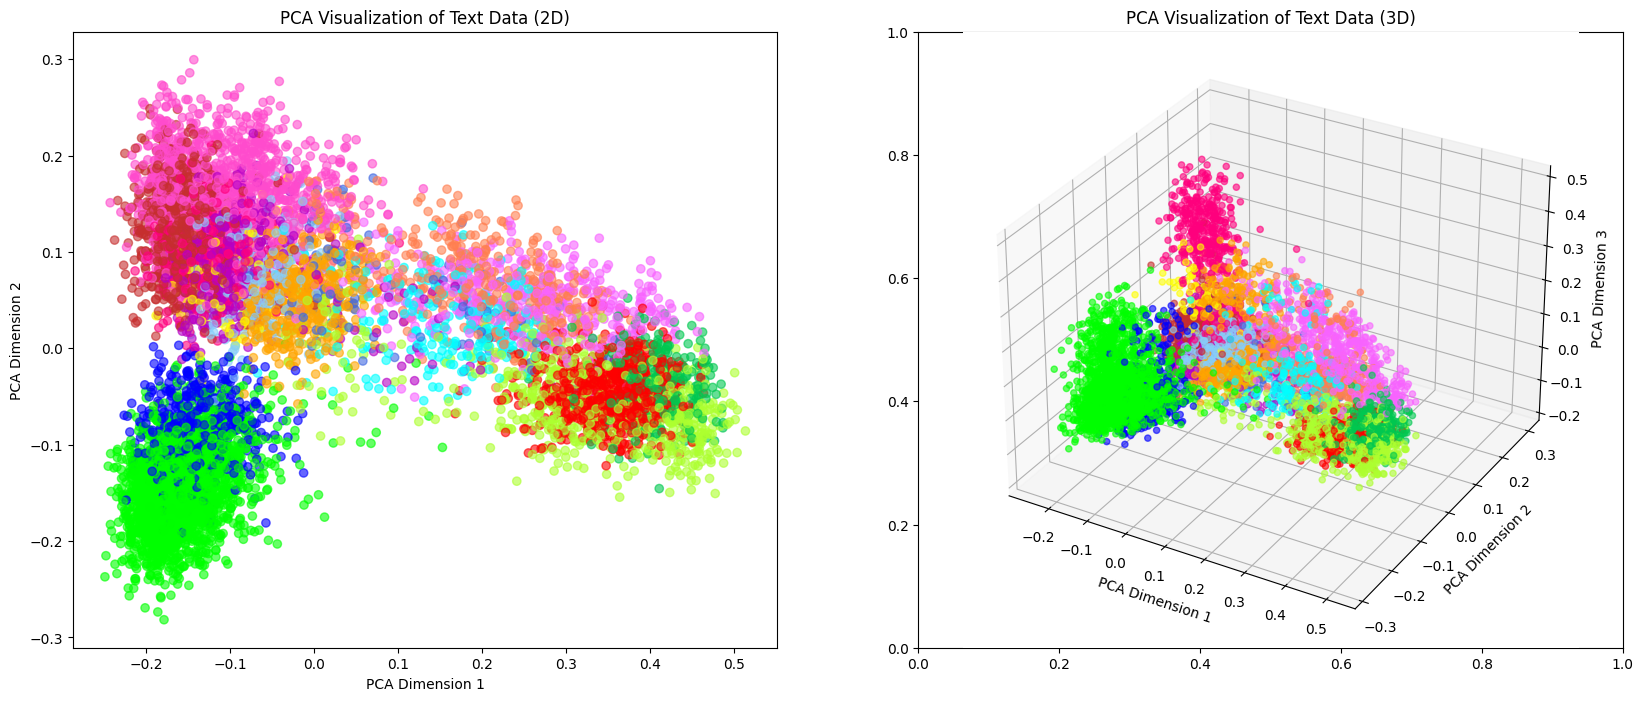

In [ ]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X.toarray())
drawClusters(X_pca, "PCA")

In [ ]:
kmeansV = {
  'ari': [], 'nmi': [], 'ami': [], 'fmi': [],
  'homogeneity': [], 'completeness': [], 'v_measure': []
}
dbscanV = {
  'ari': [], 'nmi': [], 'ami': [], 'fmi': [],
  'homogeneity': [], 'completeness': [], 'v_measure': []
}

for i in tqdm_notebook(range(1, 100)):
  X_pca = getPCA(X.toarray(), 3)
  kmean_labels = calcKmeans(X_pca, 16)
  ari, nmi, ami, fmi = getExternalValidations(df['label'], kmean_labels)
  homogeneity, completeness, v_measure = getInternalValidations(df['label'], kmean_labels)
  kmeansV['ari'].append(ari)
  kmeansV['nmi'].append(nmi)
  kmeansV['ami'].append(ami)
  kmeansV['fmi'].append(fmi)
  kmeansV['homogeneity'].append(homogeneity)
  kmeansV['completeness'].append(completeness)
  kmeansV['v_measure'].append(v_measure)

  dbscan_labels = calcDBSCAN(X_pca, 0.0225, 20)
  ari, nmi, ami, fmi = getExternalValidations(df['label'], dbscan_labels)
  homogeneity, completeness, v_measure = getInternalValidations(df['label'], dbscan_labels)
  dbscanV['ari'].append(ari)
  dbscanV['nmi'].append(nmi)
  dbscanV['ami'].append(ami)
  dbscanV['fmi'].append(fmi)
  dbscanV['homogeneity'].append(homogeneity)
  dbscanV['completeness'].append(completeness)
  dbscanV['v_measure'].append(v_measure)

kmeansV['ari'] = calculate_rms(kmeansV['ari'])
kmeansV['nmi'] = calculate_rms(kmeansV['nmi'])
kmeansV['ami'] = calculate_rms(kmeansV['ami'])
kmeansV['fmi'] = calculate_rms(kmeansV['fmi'])
kmeansV['homogeneity'] = calculate_rms(kmeansV['homogeneity'])
kmeansV['completeness'] = calculate_rms(kmeansV['completeness'])
kmeansV['v_measure'] = calculate_rms(kmeansV['v_measure'])

print("KMEANS avg:")
print(f"ari:{kmeansV['ari']:.5f}, nmi:{kmeansV['nmi']:.5f}, ami:{kmeansV['ami']:.5f}, fmi:{kmeansV['fmi']:.5f}")
print(f"homogeneity:{kmeansV['homogeneity']:.5f}, completeness:{kmeansV['completeness']:.5f}, v_measure:{kmeansV['v_measure']:.5f}")

dbscanV['ari'] = calculate_rms(dbscanV['ari'])
dbscanV['nmi'] = calculate_rms(dbscanV['nmi'])
dbscanV['ami'] = calculate_rms(dbscanV['ami'])
dbscanV['fmi'] = calculate_rms(dbscanV['fmi'])
dbscanV['homogeneity'] = calculate_rms(dbscanV['homogeneity'])
dbscanV['completeness'] = calculate_rms(dbscanV['completeness'])
dbscanV['v_measure'] = calculate_rms(dbscanV['v_measure'])
print("DBSCAN avg:")
print(f"ari:{dbscanV['ari']:.5f}, nmi:{dbscanV['nmi']:.5f}, ami:{dbscanV['ami']:.5f}, fmi:{dbscanV['fmi']:.5f}")
print(f"homogeneity:{dbscanV['homogeneity']:.5f}, completeness:{dbscanV['completeness']:.5f}, v_measure:{dbscanV['v_measure']:.5f}")

  0%|          | 0/99 [00:00<?, ?it/s]

KMEANS avg:
ari:0.45447, nmi:0.62181, ami:0.61992, fmi:0.51175
homogeneity:0.64649, completeness:0.60333, v_measure:0.62181
DBSCAN avg:
ari:0.25245, nmi:0.44945, ami:0.44748, fmi:0.40268
homogeneity:0.35575, completeness:0.61249, v_measure:0.44945


In [ ]:
kmean_labels = calcKmeans(X_pca, 16)
printValidations(df['label'], kmean_labels, "K-Means")
print()

dbscan_labels = calcDBSCAN(X_pca, 0.02, 8)
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
print(f"clusters: {n_clusters}")
printValidations(df['label'], dbscan_labels, "DBSCAN")

K-Means Validations:
ari:0.40501, nmi:0.61673, ami:0.61484, fmi:0.46761
homogeneity:0.64388, completeness:0.59177, v_measure:0.61673

clusters: 15
DBSCAN Validations:
ari:0.37638, nmi:0.49676, ami:0.49370, fmi:0.50748
homogeneity:0.40126, completeness:0.65192, v_measure:0.49676


## Clustering with LSA

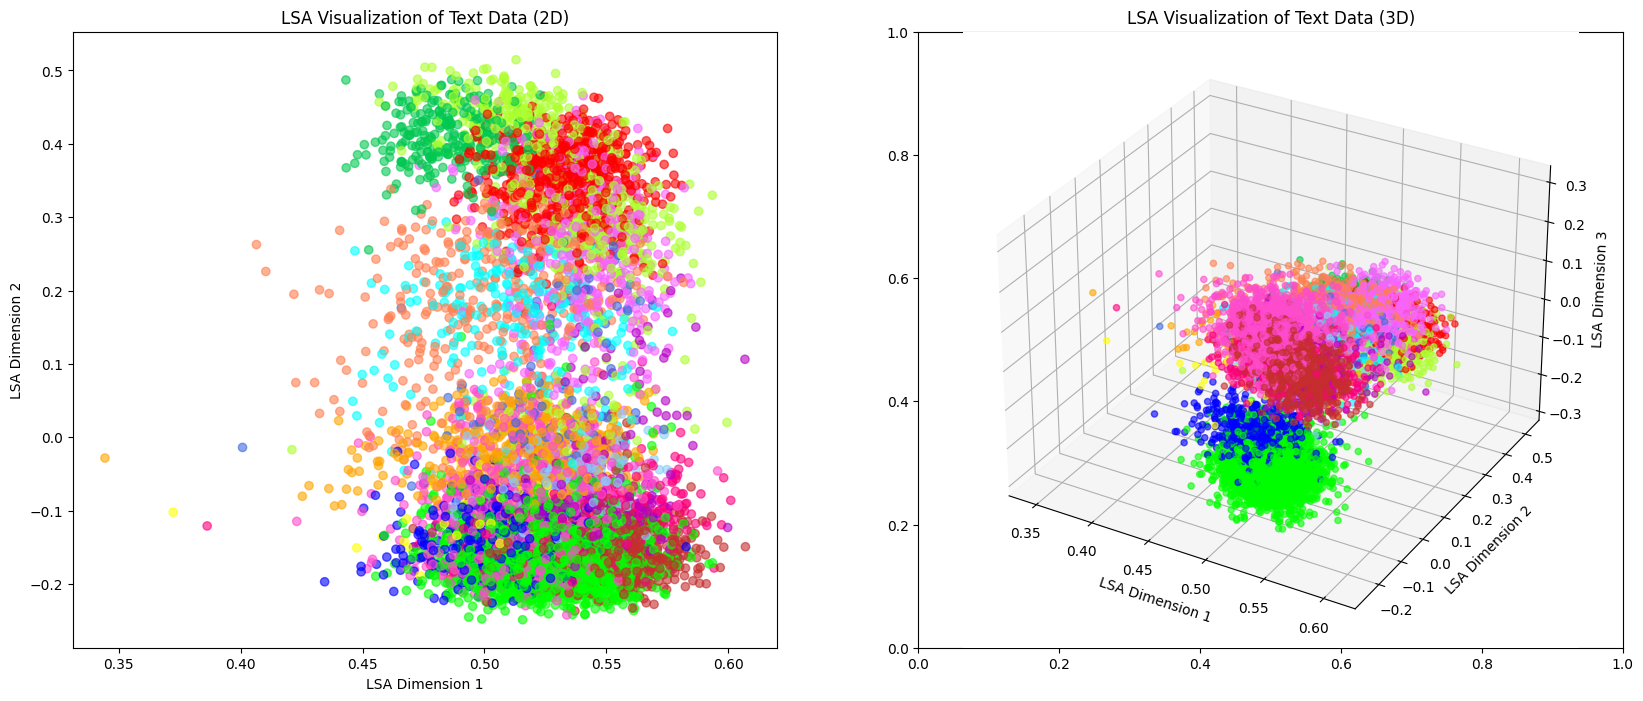

In [ ]:
lsa = TruncatedSVD(n_components=3)
X_lsa = lsa.fit_transform(X)
drawClusters(X_lsa, "LSA")

In [ ]:
kmeansV = {
  'ari': [], 'nmi': [], 'ami': [], 'fmi': [],
  'homogeneity': [], 'completeness': [], 'v_measure': []
}
dbscanV = {
  'ari': [], 'nmi': [], 'ami': [], 'fmi': [],
  'homogeneity': [], 'completeness': [], 'v_measure': []
}

for i in tqdm_notebook(range(1, 100)):
  X_lsa = getLSA(X.toarray(), 3)
  kmean_labels = calcKmeans(X_lsa, 16)
  ari, nmi, ami, fmi = getExternalValidations(df['label'], kmean_labels)
  homogeneity, completeness, v_measure = getInternalValidations(df['label'], kmean_labels)
  kmeansV['ari'].append(ari)
  kmeansV['nmi'].append(nmi)
  kmeansV['ami'].append(ami)
  kmeansV['fmi'].append(fmi)
  kmeansV['homogeneity'].append(homogeneity)
  kmeansV['completeness'].append(completeness)
  kmeansV['v_measure'].append(v_measure)

  dbscan_labels = calcDBSCAN(X_lsa, 0.0225, 20)
  ari, nmi, ami, fmi = getExternalValidations(df['label'], dbscan_labels)
  homogeneity, completeness, v_measure = getInternalValidations(df['label'], dbscan_labels)
  dbscanV['ari'].append(ari)
  dbscanV['nmi'].append(nmi)
  dbscanV['ami'].append(ami)
  dbscanV['fmi'].append(fmi)
  dbscanV['homogeneity'].append(homogeneity)
  dbscanV['completeness'].append(completeness)
  dbscanV['v_measure'].append(v_measure)

kmeansV['ari'] = calculate_rms(kmeansV['ari'])
kmeansV['nmi'] = calculate_rms(kmeansV['nmi'])
kmeansV['ami'] = calculate_rms(kmeansV['ami'])
kmeansV['fmi'] = calculate_rms(kmeansV['fmi'])
kmeansV['homogeneity'] = calculate_rms(kmeansV['homogeneity'])
kmeansV['completeness'] = calculate_rms(kmeansV['completeness'])
kmeansV['v_measure'] = calculate_rms(kmeansV['v_measure'])

print("KMEANS avg:")
print(f"ari:{kmeansV['ari']:.5f}, nmi:{kmeansV['nmi']:.5f}, ami:{kmeansV['ami']:.5f}, fmi:{kmeansV['fmi']:.5f}")
print(f"homogeneity:{kmeansV['homogeneity']:.5f}, completeness:{kmeansV['completeness']:.5f}, v_measure:{kmeansV['v_measure']:.5f}")

dbscanV['ari'] = calculate_rms(dbscanV['ari'])
dbscanV['nmi'] = calculate_rms(dbscanV['nmi'])
dbscanV['ami'] = calculate_rms(dbscanV['ami'])
dbscanV['fmi'] = calculate_rms(dbscanV['fmi'])
dbscanV['homogeneity'] = calculate_rms(dbscanV['homogeneity'])
dbscanV['completeness'] = calculate_rms(dbscanV['completeness'])
dbscanV['v_measure'] = calculate_rms(dbscanV['v_measure'])
print("DBSCAN avg:")
print(f"ari:{dbscanV['ari']:.5f}, nmi:{dbscanV['nmi']:.5f}, ami:{dbscanV['ami']:.5f}, fmi:{dbscanV['fmi']:.5f}")
print(f"homogeneity:{dbscanV['homogeneity']:.5f}, completeness:{dbscanV['completeness']:.5f}, v_measure:{dbscanV['v_measure']:.5f}")

  0%|          | 0/99 [00:00<?, ?it/s]

KMEANS avg:
ari:0.33873, nmi:0.55132, ami:0.54912, fmi:0.40585
homogeneity:0.57788, completeness:0.52751, v_measure:0.55132
DBSCAN avg:
ari:0.38568, nmi:0.50018, ami:0.49928, fmi:0.53643
homogeneity:0.38425, completeness:0.71678, v_measure:0.50018


In [ ]:
kmean_labels = calcKmeans(X_lsa, 16)
printValidations(df['label'], kmean_labels, "K-Means")
print()

dbscan_labels = calcDBSCAN(X_lsa, 0.0225, 20)
printValidations(df['label'], dbscan_labels, "DBSCAN")
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
print(f"clusters: {n_clusters}")

K-Means Validations:
ari:0.32366, nmi:0.54645, ami:0.54424, fmi:0.39205
homogeneity:0.57428, completeness:0.52119, v_measure:0.54645

DBSCAN Validations:
ari:0.38557, nmi:0.49978, ami:0.49888, fmi:0.53636
homogeneity:0.38398, completeness:0.71559, v_measure:0.49978
clusters: 4


## Clustering with TSNE

Execution time: 419.4248905181885 seconds


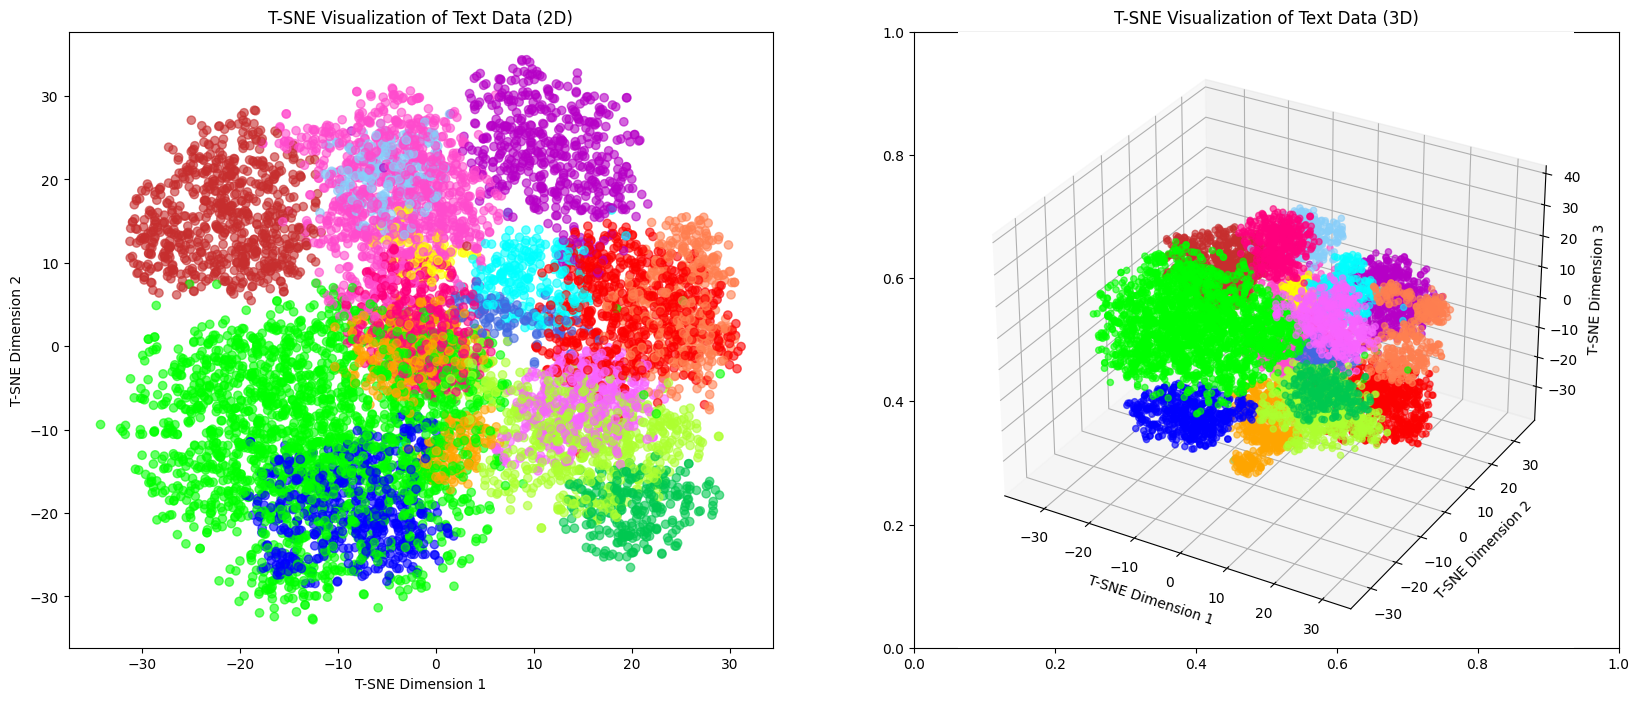

In [ ]:
start_time = time.time()

tsne = TSNE(n_components=3, perplexity=30.0)
X_tsne = tsne.fit_transform(X.toarray())

execution_time = time.time() - start_time
print(f"Execution time: {execution_time} seconds")

drawClusters(X_tsne, "T-SNE")

In [ ]:
kmeansV = {
  'ari': [], 'nmi': [], 'ami': [], 'fmi': [],
  'homogeneity': [], 'completeness': [], 'v_measure': []
}
dbscanV = {
  'ari': [], 'nmi': [], 'ami': [], 'fmi': [],
  'homogeneity': [], 'completeness': [], 'v_measure': []
}

for i in tqdm_notebook(range(1, 10)):
  X_tsne = getTSNE(X.toarray(), 3)
  kmean_labels = calcKmeans(X_tsne, 16)
  ari, nmi, ami, fmi = getExternalValidations(df['label'], kmean_labels)
  homogeneity, completeness, v_measure = getInternalValidations(df['label'], kmean_labels)
  kmeansV['ari'].append(ari)
  kmeansV['nmi'].append(nmi)
  kmeansV['ami'].append(ami)
  kmeansV['fmi'].append(fmi)
  kmeansV['homogeneity'].append(homogeneity)
  kmeansV['completeness'].append(completeness)
  kmeansV['v_measure'].append(v_measure)

  dbscan_labels = calcDBSCAN(X_tsne, 0.02, 5)
  ari, nmi, ami, fmi = getExternalValidations(df['label'], dbscan_labels)
  homogeneity, completeness, v_measure = getInternalValidations(df['label'], dbscan_labels)
  dbscanV['ari'].append(ari)
  dbscanV['nmi'].append(nmi)
  dbscanV['ami'].append(ami)
  dbscanV['fmi'].append(fmi)
  dbscanV['homogeneity'].append(homogeneity)
  dbscanV['completeness'].append(completeness)
  dbscanV['v_measure'].append(v_measure)

kmeansV['ari'] = calculate_rms(kmeansV['ari'])
kmeansV['nmi'] = calculate_rms(kmeansV['nmi'])
kmeansV['ami'] = calculate_rms(kmeansV['ami'])
kmeansV['fmi'] = calculate_rms(kmeansV['fmi'])
kmeansV['homogeneity'] = calculate_rms(kmeansV['homogeneity'])
kmeansV['completeness'] = calculate_rms(kmeansV['completeness'])
kmeansV['v_measure'] = calculate_rms(kmeansV['v_measure'])
print("KMEANS avg:")
print(f"ari:{kmeansV['ari']:.5f}, nmi:{kmeansV['nmi']:.5f}, ami:{kmeansV['ami']:.5f}, fmi:{kmeansV['fmi']:.5f}")
print(f"homogeneity:{kmeansV['homogeneity']:.5f}, completeness:{kmeansV['completeness']:.5f}, v_measure:{kmeansV['v_measure']:.5f}")

dbscanV['ari'] = calculate_rms(dbscanV['ari'])
dbscanV['nmi'] = calculate_rms(dbscanV['nmi'])
dbscanV['ami'] = calculate_rms(dbscanV['ami'])
dbscanV['fmi'] = calculate_rms(dbscanV['fmi'])
dbscanV['homogeneity'] = calculate_rms(dbscanV['homogeneity'])
dbscanV['completeness'] = calculate_rms(dbscanV['completeness'])
dbscanV['v_measure'] = calculate_rms(dbscanV['v_measure'])
print("DBSCAN avg:")
print(f"ari:{dbscanV['ari']:.5f}, nmi:{dbscanV['nmi']:.5f}, ami:{dbscanV['ami']:.5f}, fmi:{dbscanV['fmi']:.5f}")
print(f"homogeneity:{dbscanV['homogeneity']:.5f}, completeness:{dbscanV['completeness']:.5f}, v_measure:{dbscanV['v_measure']:.5f}")

In [ ]:
kmean_labels = calcKmeans(X_tsne, 16)
printValidations(df['label'], kmean_labels, "K-Means")
print()

dbscan_labels = calcDBSCAN(X_tsne, 2.5, 8)
printValidations(df['label'], dbscan_labels, "DBSCAN")
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
print(f"clusters: {n_clusters}")

K-Means Validations:
ari:0.62765, nmi:0.83846, ami:0.83768, fmi:0.68011
homogeneity:0.88176, completeness:0.79922, v_measure:0.83846

DBSCAN Validations:
ari:0.38694, nmi:0.72269, ami:0.71570, fmi:0.45164
homogeneity:0.84180, completeness:0.63311, v_measure:0.72269
clusters: 86


##2 Step TSNE

Execution time: 359.3619055747986 seconds


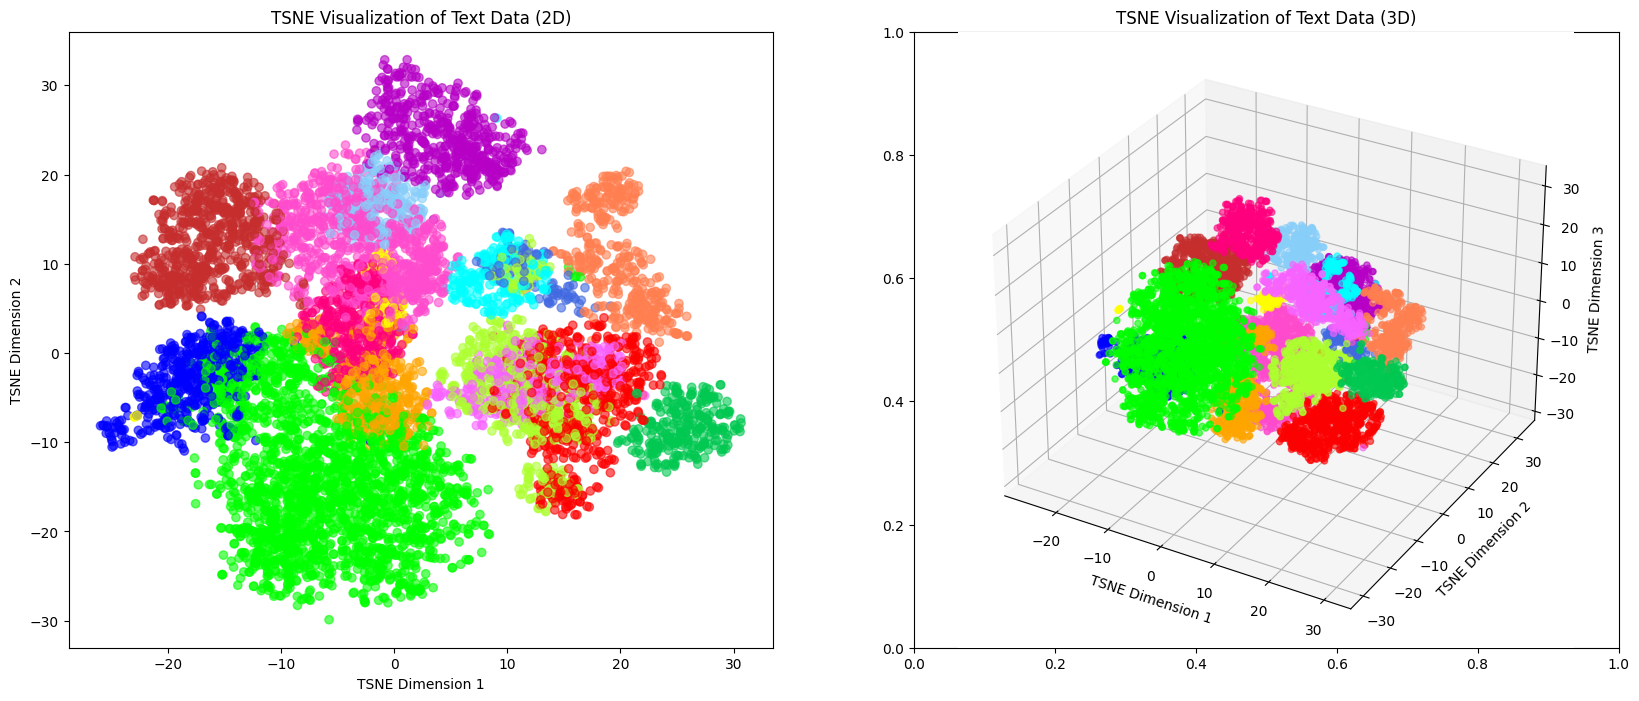

In [ ]:
start_time = time.time()

pca_100 = PCA(n_components=100)
X_pca_for_tsne = pca_100.fit_transform(X.toarray())

pca_tsne = TSNE(n_components=3, perplexity=30.0)
X_pca_tsne = pca_tsne.fit_transform(X_pca_for_tsne)

execution_time = time.time() - start_time
print(f"Execution time: {execution_time} seconds")

drawClusters(X_pca_tsne, "TSNE")

In [ ]:
X_pca_for_tsne

array([[-0.07729167,  0.15775137,  0.1765206 , ...,  0.04416744,
        -0.02550897, -0.01883526],
       [-0.21478909, -0.15341026, -0.04090898, ..., -0.02226933,
         0.05554222,  0.00182429],
       [-0.19958471,  0.15182404,  0.0190195 , ..., -0.00454781,
         0.06135867, -0.00185025],
       ...,
       [-0.0467004 ,  0.19256547, -0.07639067, ..., -0.03731105,
        -0.01527155, -0.03916025],
       [-0.16793241, -0.13514202,  0.11566453, ...,  0.07828231,
         0.0435571 , -0.0173544 ],
       [-0.11413547,  0.23354601, -0.09637808, ..., -0.01681498,
         0.02228701, -0.03333643]])

In [ ]:
author_label_list = df['author_label'].tolist()
author_label_list

In [ ]:
# prompt: download X_pca_for_tsne and reuse it as json

import json

# Convert the NumPy array to a list
X_pca_for_tsne_list = X_pca_for_tsne.tolist()

author_label_list = df['author_label'].tolist()

# Create a dictionary to store the data
data = {
    "X_pca_for_tsne": X_pca_for_tsne_list,
    "author_list": author_label_list
}

# Save the data as a JSON file
with open('X_pca_for_tsne.json', 'w') as f:
  json.dump(data, f)

# Download the file
from google.colab import files
files.download('X_pca_for_tsne.json')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
kmeans_final = KMeans(n_clusters=16)
kmeans_final.fit(X_pca_tsne)
kmean_labels = kmeans_final.labels_

printValidations(df['label'], kmean_labels, "K-Means")
print()

dbscan_final = DBSCAN(eps=2.5, min_samples=4)
dbscan_final.fit(X_pca_tsne)
dbscan_labels = dbscan_final.labels_

printValidations(df['label'], dbscan_labels, "DBSCAN")
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
print(f"clusters: {n_clusters}")

K-Means Validations:
ari:0.63980, nmi:0.86097, ami:0.86029, fmi:0.69009
homogeneity:0.90305, completeness:0.82264, v_measure:0.86097

DBSCAN Validations:
ari:0.90303, nmi:0.92590, ami:0.92529, fmi:0.91380
homogeneity:0.93125, completeness:0.92061, v_measure:0.92590
clusters: 26


Execution time: 357.2173764705658 seconds


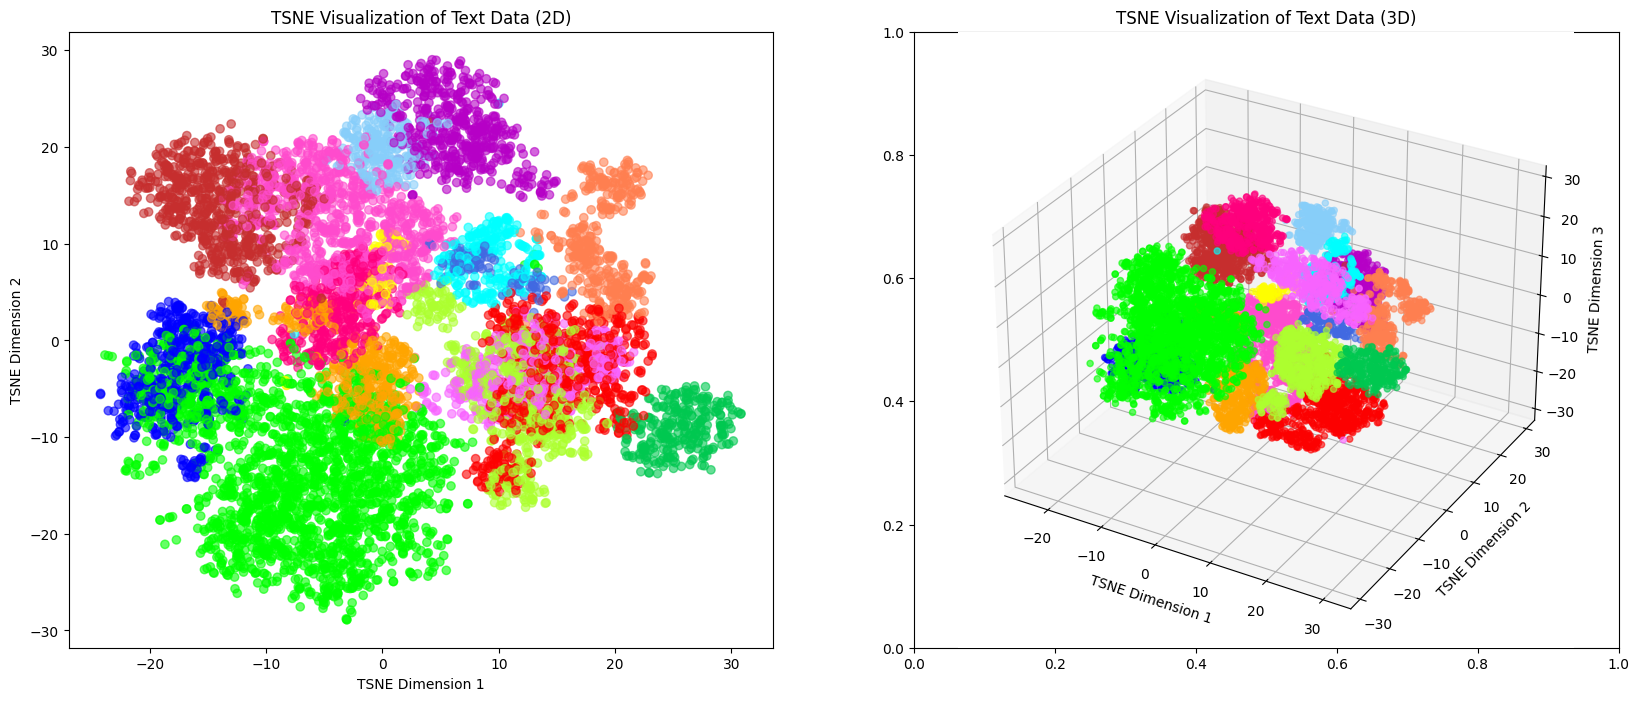

In [ ]:
start_time = time.time()

lsa_100 = TruncatedSVD(n_components=100)
X_lsa_for_tsne = lsa_100.fit_transform(X)

lsa_tsne = TSNE(n_components=3, perplexity=30.0)
X_lsa_tsne = lsa_tsne.fit_transform(X_lsa_for_tsne)

execution_time = time.time() - start_time
print(f"Execution time: {execution_time} seconds")

drawClusters(X_lsa_tsne, "TSNE")

In [ ]:
kmean_labels = calcKmeans(X_lsa_tsne, 16)
printValidations(df['label'], kmean_labels, "K-Means")
print()

dbscan_labels = calcDBSCAN(X_lsa_tsne, 2.5, 4)
printValidations(df['label'], dbscan_labels, "DBSCAN")
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
print(f"clusters: {n_clusters}")

K-Means Validations:
ari:0.64366, nmi:0.86408, ami:0.86342, fmi:0.69498
homogeneity:0.90812, completeness:0.82412, v_measure:0.86408

DBSCAN Validations:
ari:0.79941, nmi:0.89738, ami:0.89672, fmi:0.83215
homogeneity:0.84665, completeness:0.95457, v_measure:0.89738
clusters: 19


In [ ]:
author_label_map = dict(zip(df['label'], df['author_label']))
author_label_map

{'shunil_gongopaddhay': 12,
 'humayun_ahmed': 2,
 'shomresh': 8,
 'shordindu': 9,
 'tarashonkor': 13,
 'shottojit_roy': 11,
 'shirshendu': 7,
 'toslima_nasrin': 14,
 'zahir_rayhan': 15,
 'nihar_ronjon_gupta': 5,
 'robindronath': 6,
 'shorotchandra': 10,
 'manik_bandhopaddhay': 3,
 'nazrul': 4,
 'bongkim': 1,
 'MZI': 0}

In [ ]:
color_palette_author_map = {author_label_map[key]: value for key, value in zip(df['label'].unique(), color_palette)}
color_palette_author_map

{12: '#0000FF',
 2: '#00C850',
 8: '#00FF00',
 9: '#00FFFF',
 13: '#4169E1',
 11: '#87CEFA',
 7: '#ADFF2F',
 14: '#B600C6',
 15: '#C62E2E',
 5: '#F863FF',
 6: '#FD0101',
 10: '#FF007D',
 3: '#FF4BCD',
 4: '#FF7F50',
 1: '#FFA500',
 0: '#FFFF00'}

In [ ]:
import json

data = []
for i in range(len(X_pca_tsne)):
  point = {
      "x": float(X_pca_tsne[i][0]),
      "y": float(X_pca_tsne[i][1]),
      "z": float(X_pca_tsne[i][2]),
      "label": int(df['author_label'][i])
  }
  data.append(point)

print(data)

json_data = json.dumps(data)

with open('X_pca_tsne_coordinates.json', 'w') as f:
  f.write(json_data)

from google.colab import files
files.download('X_pca_tsne_coordinates.json')


[{'x': -2.9705610275268555, 'y': 0.698932409286499, 'z': 13.961226463317871, 'label': 12}, {'x': -10.787182807922363, 'y': -17.1765193939209, 'z': 6.27002477645874, 'label': 2}, {'x': -18.677082061767578, 'y': 15.03152084350586, 'z': -0.20713092386722565, 'label': 8}, {'x': -15.533587455749512, 'y': -24.48187828063965, 'z': 3.804190158843994, 'label': 2}, {'x': 17.992401123046875, 'y': 3.935847282409668, 'z': 11.427940368652344, 'label': 9}, {'x': 19.165729522705078, 'y': 16.100412368774414, 'z': 7.877890586853027, 'label': 13}, {'x': -5.0947065353393555, 'y': 6.245250701904297, 'z': 24.80042839050293, 'label': 11}, {'x': 5.379678249359131, 'y': -12.75131607055664, 'z': 5.408899307250977, 'label': 2}, {'x': 1.4200639724731445, 'y': 17.87050437927246, 'z': -5.329768180847168, 'label': 7}, {'x': 3.5818490982055664, 'y': 3.9660472869873047, 'z': -0.14974339306354523, 'label': 14}, {'x': -1.7903207540512085, 'y': 10.9267578125, 'z': 11.026270866394043, 'label': 15}, {'x': -9.87022781372070

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import joblib

joblib.dump(vectorizer, 'vectorizer.pkl')
files.download('vectorizer.pkl')

joblib.dump(pca_100, 'pca_100.pkl')
files.download('pca_100.pkl')

joblib.dump(pca_tsne, 'pca_tsne.pkl')
files.download('pca_tsne.pkl')

joblib.dump(kmeans_final, 'kmeans.pkl')
files.download('kmeans.pkl')

joblib.dump(dbscan_final, 'dbscan.pkl')
files.download('dbscan.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>